# Malaria Life-Cycle Stage Classification with DenseNet
This notebook uses **DenseNet121** for image classification to recognize malaria life-cycle stages in thin blood smear images.

In [1]:
import os, json, random, itertools
from collections import Counter
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms, models


In [2]:
# Path to dataset images and annotation file
DATA_DIR = '../IML_Malaria'
ANN_FILE = '../annotations.json'

with open(ANN_FILE) as f:
    annotations = json.load(f)

# Flatten annotations into a list of records with bbox and label
dataset_records = []
for entry in annotations:
    img_name = entry['image_name']
    for obj in entry['objects']:
        label = obj['type']
        bbox = [int(obj['bbox']['x']), int(obj['bbox']['y']),
                int(obj['bbox']['w']), int(obj['bbox']['h'])]
        dataset_records.append({'image': img_name, 'label': label, 'bbox': bbox})

labels = [rec['label'] for rec in dataset_records]
print('Total objects:', len(labels))
print(Counter(labels))


Total objects: 38449
Counter({'red blood cell': 37899, 'gametocyte': 261, 'ring': 164, 'trophozoite': 77, 'schizont': 27, 'difficult': 21})


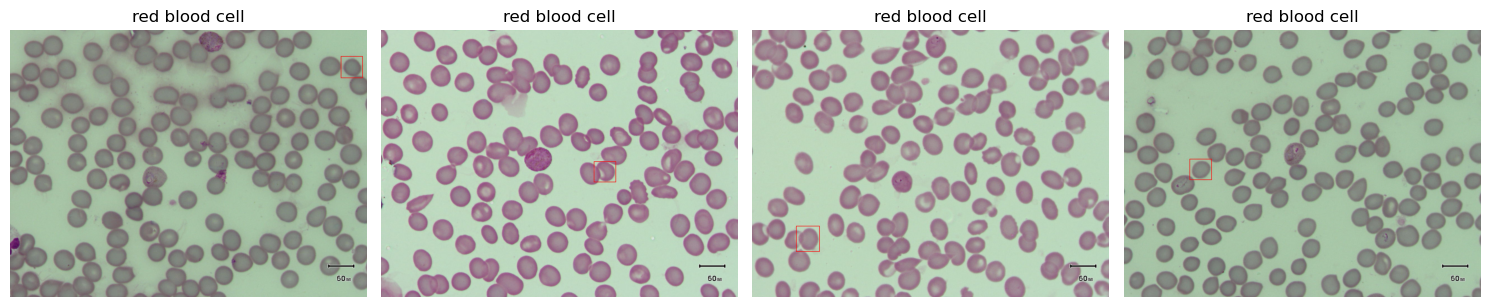

In [3]:
# Visualize random samples with bounding boxes
samples = random.sample(dataset_records, 4)
fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
for ax, rec in zip(axes, samples):
    img = Image.open(os.path.join(DATA_DIR, rec['image'])).convert('RGB')
    draw = ImageDraw.Draw(img)
    x, y, w, h = rec['bbox']
    draw.rectangle([x, y, x+w, y+h], outline='red', width=2)
    ax.imshow(img)
    ax.set_title(rec['label'])
    ax.axis('off')
plt.tight_layout()


In [4]:
# Map string labels to indices
classes = sorted(set(labels))
label2idx = {c: i for i, c in enumerate(classes)}
idx2label = {i: c for c, i in label2idx.items()}

# Data augmentation and preprocessing
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:
class MalariaDataset(Dataset):
    def __init__(self, records, transform=None):
        self.records = records
        self.transform = transform

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec = self.records[idx]
        img = Image.open(os.path.join(DATA_DIR, rec['image'])).convert('RGB')
        x, y, w, h = rec['bbox']
        img = img.crop((x, y, x+w, y+h))
        if self.transform:
            img = self.transform(img)
        label = label2idx[rec['label']]
        return img, label


In [6]:
# Shuffle and split the records
def split_dataset(records, train_ratio=0.7, val_ratio=0.15):
    random.shuffle(records)
    n = len(records)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    return records[:train_end], records[train_end:val_end], records[val_end:]

train_records, val_records, test_records = split_dataset(dataset_records)

print(len(train_records), len(val_records), len(test_records))


26914 5767 5768


In [7]:
# Compute class weights for WeightedRandomSampler
train_labels = [r['label'] for r in train_records]
label_counts = Counter(train_labels)
weights = [1.0 / label_counts[r['label']] for r in train_records]
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_records), replacement=True)

train_ds = MalariaDataset(train_records, transform=train_transforms)
val_ds = MalariaDataset(val_records, transform=val_transforms)
test_ds = MalariaDataset(test_records, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(classes))
)
model.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

def train_epoch(loader):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def eval_epoch(loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


In [10]:
num_epochs = 10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = eval_epoch(val_loader)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train loss: {train_loss:.4f} acc: {train_acc:.4f} | '
          f'Val loss: {val_loss:.4f} acc: {val_acc:.4f}')


KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history['train_loss'], label='train')
ax1.plot(history['val_loss'], label='val')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(history['train_acc'], label='train')
ax2.plot(history['val_acc'], label='val')
ax2.set_title('Accuracy')
ax2.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))
cm = confusion_matrix(all_labels, all_preds)


In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Grad-CAM visualization for interpretability
# Install grad-cam library if not available
!pip install -q pytorch-grad-cam

try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
except ImportError:
    print('Install pytorch-grad-cam to use Grad-CAM')

# Choose a test image
sample_img, sample_label = test_ds[0]
input_tensor = sample_img.unsqueeze(0).to(device)

# Target layer for DenseNet121
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=device.type=='cuda')
mask = cam(input_tensor)[0]
img = sample_img.permute(1,2,0).numpy()
heatmap = show_cam_on_image(img, mask, use_rgb=True)
plt.imshow(heatmap)
plt.title(f'True: {idx2label[sample_label]}')
plt.axis('off')
plt.show()


In [ ]:
torch.save(model.state_dict(), 'densenet_malaria.pth')
